<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/NeuralProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Prophet

![](https://user-images.githubusercontent.com/21246060/111388960-6c367e80-866d-11eb-91c1-46f2c0d21879.PNG)

## Explainable Forecasting at Scale
* https://arxiv.org/pdf/2111.15397.pdf (NeuralProphet)
* https://arxiv.org/pdf/1911.12436.pdf (AR-Net)

## Features
* Interfaces for Python
  * Automated forecasting with tuning
  * Based on PyTorch
* ...
* Future Work
  * Logistic Growth of Trend
  * Uncertainty Estimation

# Install

In [1]:
!pip install neuralprophet
!pip install pystan~=2.14
!pip install fbprophet
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from google.colab import files

from fbprophet import Prophet
from neuralprophet import NeuralProphet

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Data

## Kaggle

In [3]:
if not os.path.exists('~/.kaggle/kaggle.json'):
  file = files.upload()
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d AnalyzeBoston/crimes-in-boston -p ./boston-crimes
!unzip -o ./boston-crimes/crimes-in-boston.zip -d ./boston-crimes

crimes-in-boston.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./boston-crimes/crimes-in-boston.zip
  inflating: ./boston-crimes/crime.csv  
  inflating: ./boston-crimes/offense_codes.csv  


In [5]:
df = pd.read_csv('./boston-crimes/crime.csv', encoding='ISO-8859-1')

In [6]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [7]:
df.dtypes

INCIDENT_NUMBER         object
OFFENSE_CODE             int64
OFFENSE_CODE_GROUP      object
OFFENSE_DESCRIPTION     object
DISTRICT                object
REPORTING_AREA          object
SHOOTING                object
OCCURRED_ON_DATE        object
YEAR                     int64
MONTH                    int64
DAY_OF_WEEK             object
HOUR                     int64
UCR_PART                object
STREET                  object
Lat                    float64
Long                   float64
Location                object
dtype: object

## Cleaning

In [8]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'])
df.index = df['OCCURRED_ON_DATE']
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
OCCURRED_ON_DATE,,,,,,,,,,,,,,,,,
2018-09-02 13:00:00,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
2018-08-21 00:00:00,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2018-09-03 19:27:00,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
2018-09-03 21:16:00,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
2018-09-03 21:05:00,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [9]:
crime_df = df[['INCIDENT_NUMBER']].resample(rule='H').count()
crime_df.columns=['Count']
crime_df.head()

,Count
OCCURRED_ON_DATE,
2015-06-15 00:00:00,14
2015-06-15 01:00:00,10
2015-06-15 02:00:00,7
2015-06-15 03:00:00,3
2015-06-15 04:00:00,1


Text(0.5, 1.0, 'Boston Total Crimes by Day')

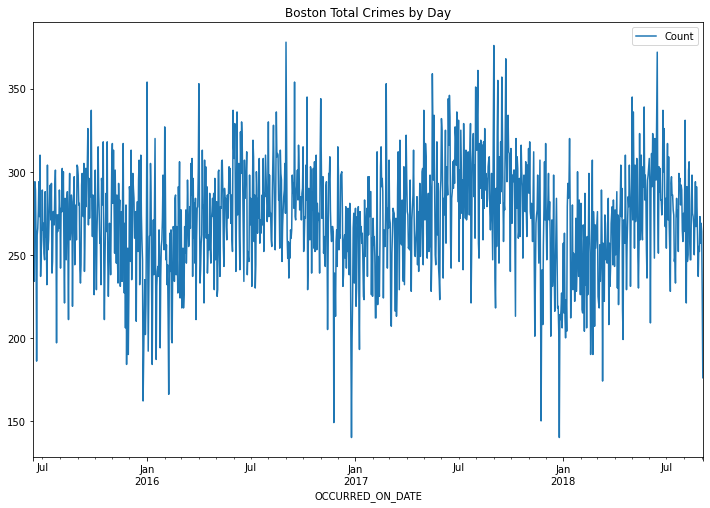

In [10]:
crime_df.resample(rule='D').sum().plot(figsize=(12,8));
plt.title('Boston Total Crimes by Day')

# NeuralProphet

In [11]:
p_df = crime_df.resample(rule='D').sum()
p_df['ds'] = p_df.index
p_df = p_df.rename(columns={'Count':'y'})
p_df.head()

,y,ds
OCCURRED_ON_DATE,,
2015-06-15,249,2015-06-15
2015-06-16,249,2015-06-16
2015-06-17,234,2015-06-17
2015-06-18,294,2015-06-18
2015-06-19,289,2015-06-19


In [12]:
model = NeuralProphet()
model.fit(p_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.915% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 184
INFO:NP.config:Auto-set epochs to 184


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.48E-02, min: 1.39E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.48E-02, min: 1.39E+00


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.48E-02, min: 1.00E+00
INFO:NP.utils_torch:lr-range-test results: steep: 8.48E-02, min: 1.00E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.96E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.96E-02
Epoch[184/184]: 100%|██████████| 184/184 [00:23<00:00,  7.91it/s, SmoothL1Loss=0.01, MAE=19.8, RMSE=25.4, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.691200,200.414959,244.594278,0.0
1,0.633567,188.945707,230.721604,0.0
2,0.566583,175.378777,214.655564,0.0
3,0.486337,158.799861,194.770788,0.0
4,0.389666,138.240695,169.800228,0.0
...,...,...,...,...
179,0.010052,19.852072,25.463561,0.0
180,0.010047,19.845399,25.385622,0.0
181,0.010044,19.838799,25.522054,0.0
182,0.010040,19.833893,25.482724,0.0


## Forecast
* To forecast, make a data frame of the future points
* Run predict on the future data frame
* Returned information includes prediction intervals and point estimates

In [13]:
future = model.make_future_dataframe(p_df, periods=365)
future

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.915% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


,ds,y
0,2018-09-04,None
1,2018-09-05,None
2,2018-09-06,None
3,2018-09-07,None
4,2018-09-08,None
...,...,...
360,2019-08-30,None
361,2019-08-31,None
362,2019-09-01,None
363,2019-09-02,None


In [14]:
forecasted = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


In [15]:
forecasted.head()

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2018-09-04,None,268.965698,NaN,251.064621,12.860442,5.040641
1,2018-09-05,None,271.149292,NaN,250.971649,12.777667,7.399958
2,2018-09-06,None,270.479858,NaN,250.878662,12.712484,6.888724
3,2018-09-07,None,281.057556,NaN,250.785706,12.663859,17.608015
4,2018-09-08,None,258.858368,NaN,250.692719,12.630548,-4.464907


## Visualize

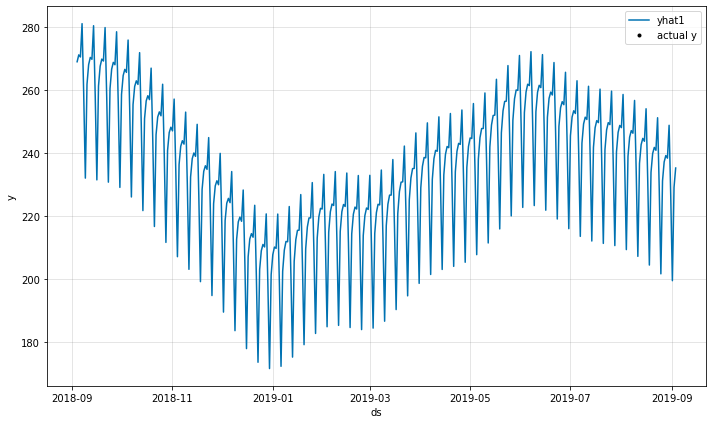

In [16]:
model.plot(forecasted);

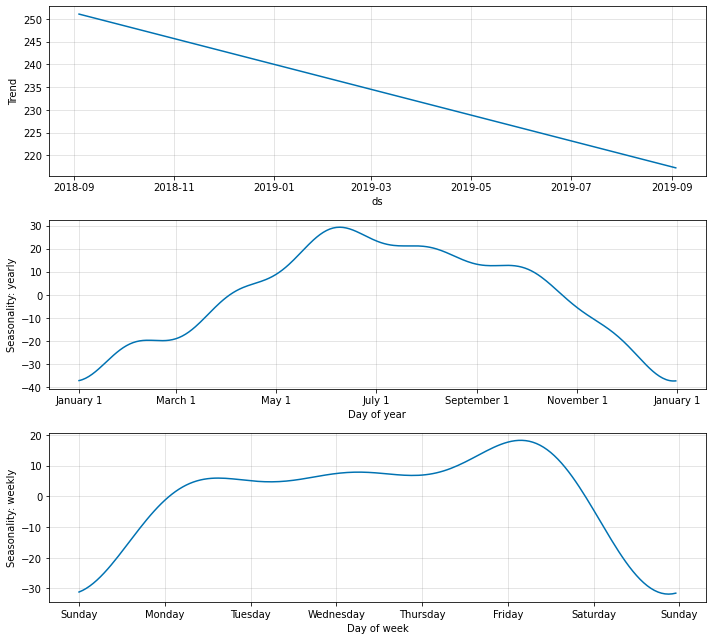

In [17]:
model.plot_components(forecasted);

# Train - Test Evaluation

In [18]:
results_df = pd.DataFrame(columns=['MAE', 'MAPE'])

## Data

In [19]:
tt_df = crime_df.resample(rule='D').sum()
tt_df['ds'] = p_df.index
tt_df = p_df.rename(columns={'Count':'y'})

train = tt_df[:1147]
test  = tt_df[1147:]

## Baseline

### Model

In [20]:
model = auto_arima(train['y'])

In [21]:
model

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Forecast

In [22]:
keys = test['ds']
pred = model.predict(n_periods=30)
forecasted = pd.DataFrame({'ds':keys, 'yhat':pred})

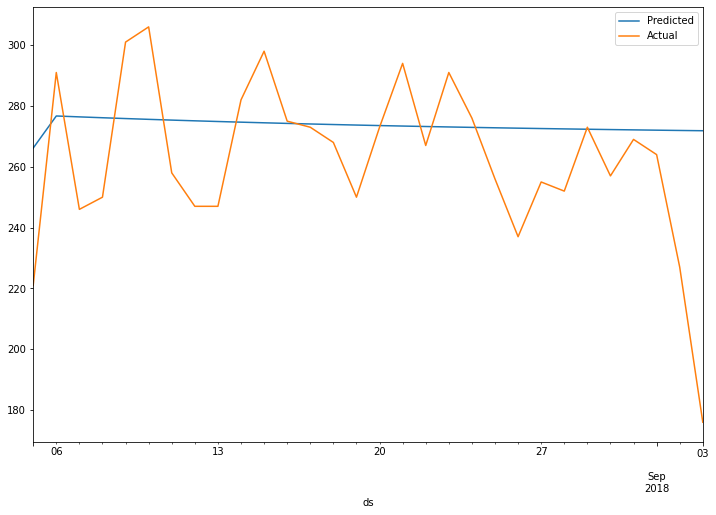

In [23]:
ax = forecasted.plot(x='ds', y='yhat', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax);

### Error

In [24]:
pred = forecasted.iloc[-30:]['yhat']
actual = test['y']

In [25]:
mae = mean_absolute_error(actual, pred)
mape = mean_absolute_percentage_error(actual, pred)
results_df.loc['ARIMA'] = [mae, mape]

## Prophet

### Model

In [26]:
model_p = Prophet()
model_p.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecast

In [27]:
future_p = model_p.make_future_dataframe(periods=30, freq='D')
forecasted_p = model_p.predict(future_p)

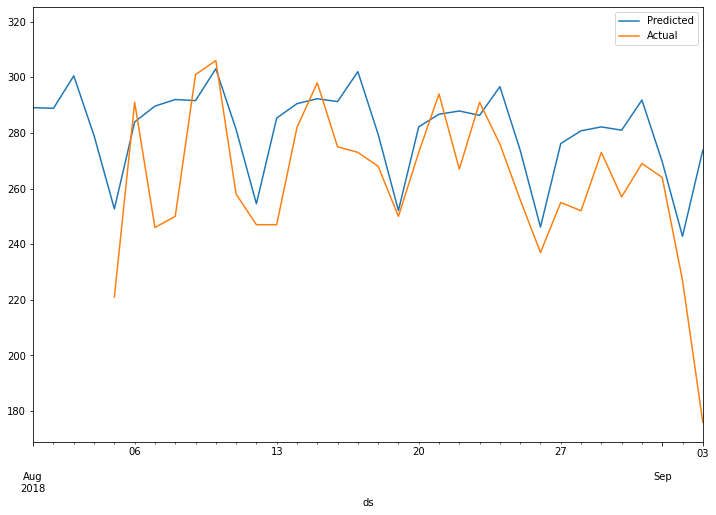

In [28]:
ax = forecasted_p.plot(x='ds', y='yhat', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax, 
          xlim=('2018-08-01', '2018-09-03'));

### Error

In [29]:
pred = forecasted_p.iloc[-30:]['yhat']
actual = test['y']

In [30]:
mae = mean_absolute_error(actual, pred)
mape = mean_absolute_percentage_error(actual, pred)
results_df.loc['Prophet'] = [mae, mape]

## NeuralProphet

### Model

In [31]:
model_np = NeuralProphet()
model_np.fit(train)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.913% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 186
INFO:NP.config:Auto-set epochs to 186


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.20E-01, min: 1.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.20E-01, min: 1.00E-01


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.20E-01, min: 1.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.20E-01, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.73E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.73E-01
Epoch[186/186]: 100%|██████████| 186/186 [00:21<00:00,  8.70it/s, SmoothL1Loss=0.01, MAE=20, RMSE=25.6, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.634513,191.320562,227.532236,0.0
1,0.392162,140.312794,170.040977,0.0
2,0.211617,97.633605,119.733411,0.0
3,0.125636,76.602469,91.443867,0.0
4,0.092418,65.527491,78.206931,0.0
...,...,...,...,...
181,0.010070,20.088348,25.709360,0.0
182,0.010044,20.043703,25.543623,0.0
183,0.010022,20.017009,25.593259,0.0
184,0.010009,20.004547,25.623598,0.0


### Forecast

In [32]:
forecasted_np = model_np.predict(test)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


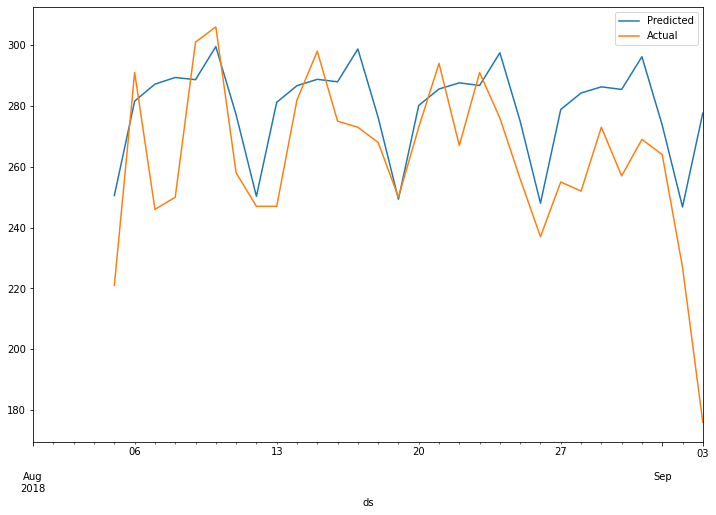

In [33]:
ax = forecasted_np.plot(x='ds', y='yhat1', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax, 
          xlim=('2018-08-01', '2018-09-03'));

### Error

In [34]:
pred = forecasted_np['yhat1']
actual = forecasted_np['y']

In [35]:
mae = mean_absolute_error(actual, pred)
mape = mean_absolute_percentage_error(actual, pred)
results_df.loc['NeuralProphet'] = [mae, mape]

## Auto-Regressive NeuralProphet

### Model

In [36]:
model_np_ar = NeuralProphet(n_lags=7)
model_np_ar.fit(train)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.913% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 186
INFO:NP.config:Auto-set epochs to 186


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.39E-02, min: 1.64E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.39E-02, min: 1.64E+00


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.39E-02, min: 1.00E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.39E-02, min: 1.00E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.78E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.78E-02
Epoch[186/186]: 100%|██████████| 186/186 [00:22<00:00,  8.40it/s, SmoothL1Loss=0.00954, MAE=19.6, RMSE=24.9, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.910999,440.751464,463.258769,0.0
1,1.753929,411.639919,435.674178,0.0
2,1.565934,376.668599,402.167260,0.0
3,1.330182,332.169020,359.759816,0.0
4,1.036661,275.367607,306.140154,0.0
...,...,...,...,...
181,0.009552,19.619561,24.991494,0.0
182,0.009547,19.617716,25.033455,0.0
183,0.009541,19.608410,24.970804,0.0
184,0.009540,19.608217,24.999773,0.0


### Forecast

In [37]:
forecasted_np_ar = model_np_ar.predict(pd.concat([train, test]))
forecasted_np_ar = forecasted_np_ar[forecasted_np_ar.ds >= '2018-08-05']

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.915% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.915% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


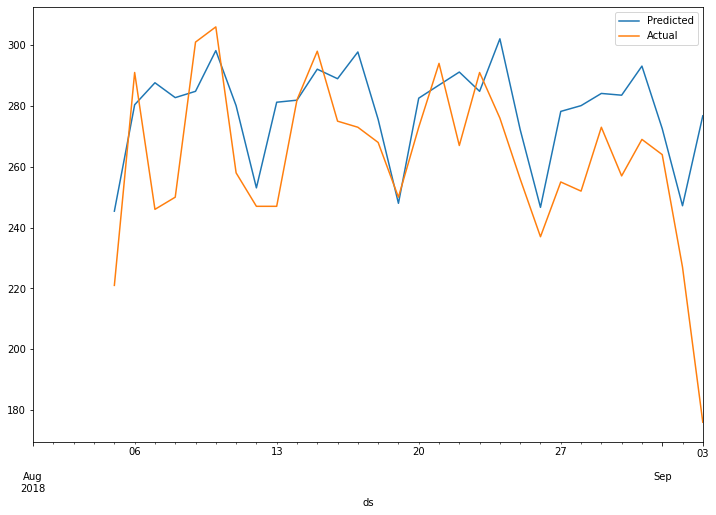

In [38]:
ax = forecasted_np_ar.plot(x='ds', y='yhat1', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax, 
          xlim=('2018-08-01', '2018-09-03'));

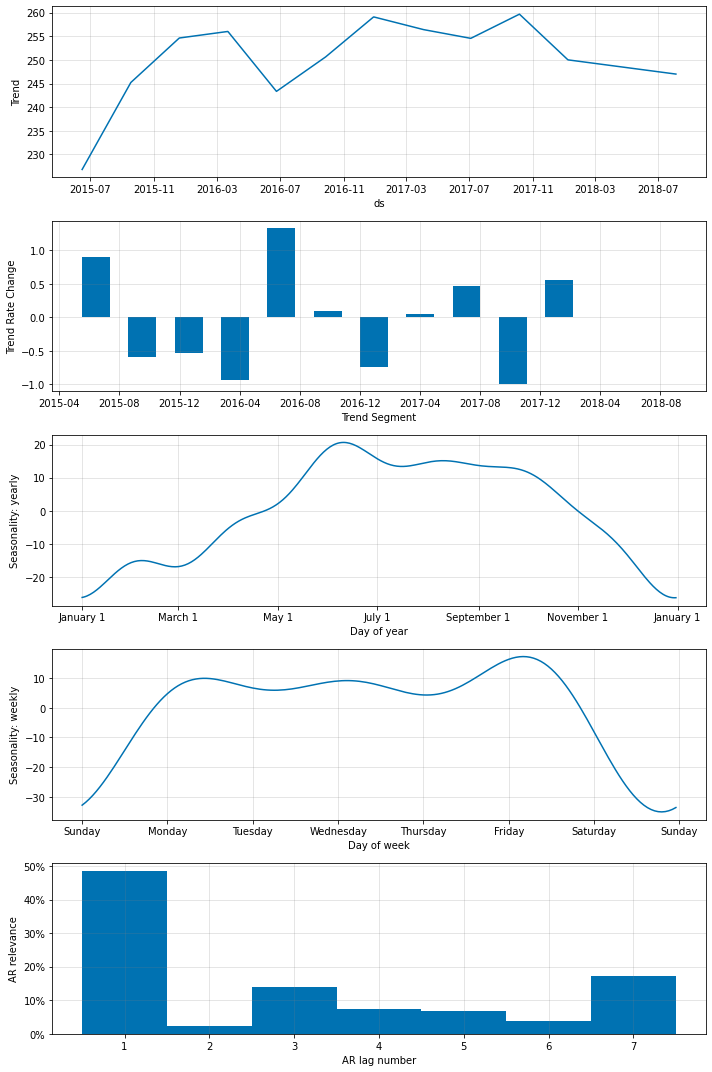

In [39]:
model_np_ar.plot_parameters();

### Error

In [40]:
pred = forecasted_np_ar['yhat1']
actual = forecasted_np_ar['y']

In [41]:
mae = mean_absolute_error(actual, pred)
mape = mean_absolute_percentage_error(actual, pred)
results_df.loc['NeuralProphet-AR'] = [mae, mape]

## Sparse Auto-Regressive NeuralProphet

### Model
* Let's add regularization to the model on AR lags
* Typical Values:
  * 0.1 - Small (Very few to zero)
  * 1 - Medium 
  * 10 - Large (Pushes most to zero)

In [50]:
model_sparse_np_ar = NeuralProphet(n_lags=90, ar_reg=1)
model_sparse_np_ar.fit(train)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.913% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 191
INFO:NP.config:Auto-set epochs to 191


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.75E-02, min: 4.97E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.75E-02, min: 4.97E-01


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.96E-02, min: 4.21E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.96E-02, min: 4.21E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.55E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 5.55E-02
Epoch[191/191]: 100%|██████████| 191/191 [00:25<00:00,  7.48it/s, SmoothL1Loss=0.00945, MAE=19.6, RMSE=24.9, RegLoss=0.00146]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.854214,234.120241,281.128861,0.000000
1,0.523293,166.613707,204.800942,0.000000
2,0.482512,159.014905,194.333871,0.000000
3,0.435336,149.058684,182.349222,0.000000
4,0.382221,137.534259,168.199873,0.000000
...,...,...,...,...
186,0.009494,19.661750,24.953094,0.001446
187,0.009452,19.617139,24.983848,0.001456
188,0.009456,19.618997,24.917265,0.001458
189,0.009457,19.621668,24.785658,0.001462


### Forecast

In [51]:
forecasted_sparse_np_ar = model_sparse_np_ar.predict(pd.concat([train, test]))
forecasted_sparse_np_ar = forecasted_sparse_np_ar[forecasted_sparse_np_ar.ds >= '2018-08-05']

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.915% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.915% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.915% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


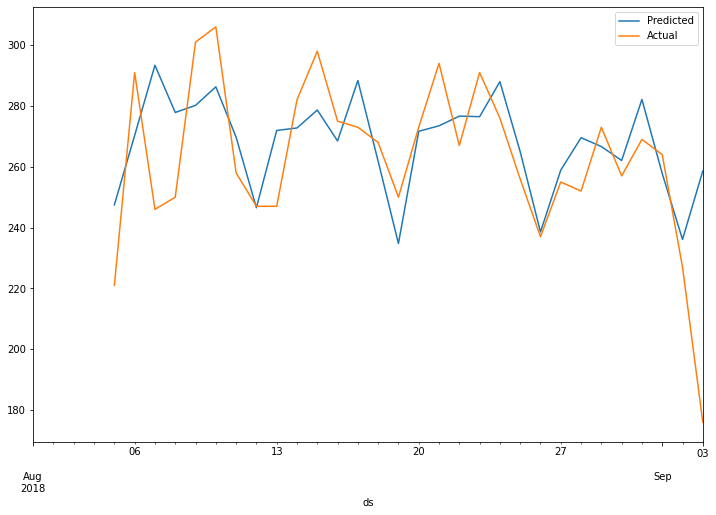

In [52]:
ax = forecasted_sparse_np_ar.plot(x='ds', y='yhat1', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax, 
          xlim=('2018-08-01', '2018-09-03'));

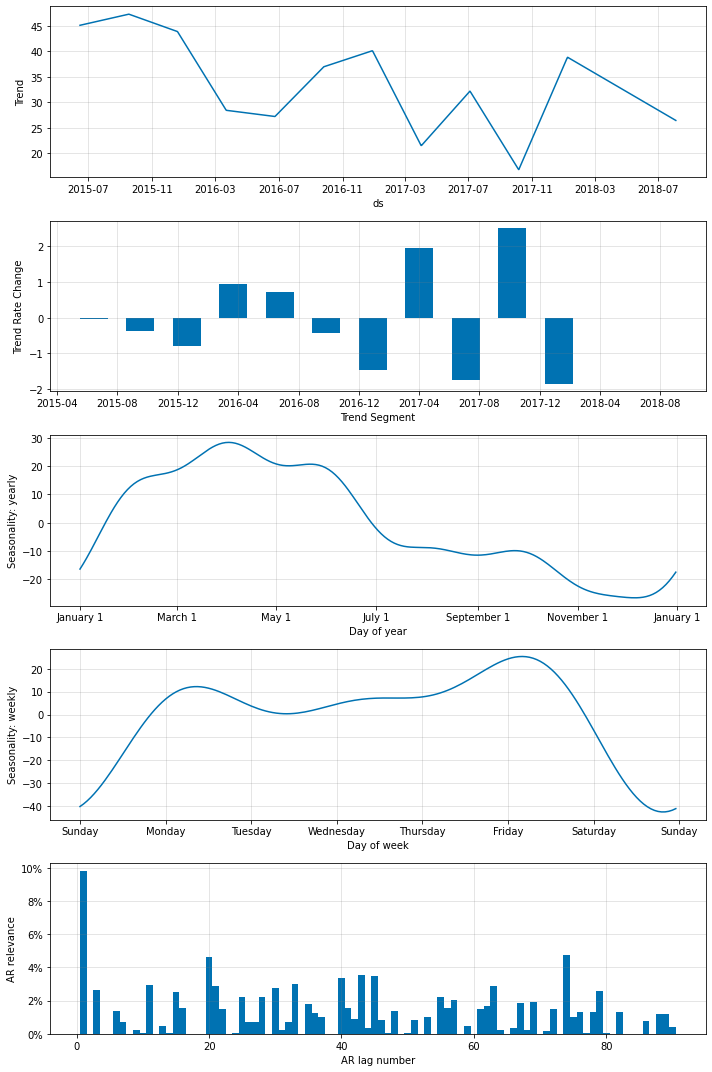

In [53]:
model_sparse_np_ar.plot_parameters();

### Error

In [54]:
pred = forecasted_sparse_np_ar['yhat1']
actual = forecasted_sparse_np_ar['y']

In [55]:
mae = mean_absolute_error(actual, pred)
mape = mean_absolute_percentage_error(actual, pred)
results_df.loc['NeuralProphet-Sparse-AR'] = [mae, mape]

## Comparison

In [56]:
results_df.sort_values('MAPE')

,MAE,MAPE
NeuralProphet-Sparse-AR,16.148372,0.066472
NeuralProphet-AR,19.719970,0.082416
Prophet,19.791884,0.082905
NeuralProphet,20.151904,0.084334
ARIMA,20.464302,0.085591


# Key Differences
* Positives
  * Autoregressive Terms - AR-Net
  * Lagged Covariates
  * NeuralNetwork - Flexibility
  * Inference Speed
* Negatives (Activity in Github)
  * Uncertainty 
  * Logistic Growth on Trend
